# Predicting Sale Prices for Ames Iowa Housing Dataset
By: Aryeh Gelfand(https://git.generalassemb.ly/aryehgelfand)

## Problem Statement

I have been hired by the Ames Iowa Organization of Real Estate Agents in order to help them create better pricing models. Right now, they are using primitive comparative pricing metrics that aren't fit to the data available for the town.
We have a dataset curated by Dr.Dean De Cock, a professor at Truman State University, that tracks 2051 real estate transactions that took place between 2006 and 2010 with 81 characteristics. We have been hired to create better price modeling for these real estate agents in order to help them add value to thier clients.

The plan is to use this data set to train a model that can accurately predict pricing, the metric we are using for success is Root Mean Squared Error, we will see how low we can get our it.
* We will start by evaluating our features 
* Searching the dataframe for missing data
* filling in missing data with proportional data points
* generating new interaction terms
* Training Linear Regression, LR with Ridge regularization and LASSO Regularization.
* Then we will evaluate the models and choose the one with the lowest RMSE



##  Executive Summary

#### Data Cleaning
This resulted in a large amount of null values. We also changed  values proportional to the values that we had. 
Then we changed categorical values that were ordinal to integer values. We also created dummy columns.

##### EDA
We got the features with the top correlation coefficient and made interaction terms with them. Then made pair plots of these top performing features. 
We also engineered 12 new features based on categories likely to be related. Then we checked the correlation for these new values and scored them.

#### Modeling
We split the data into train and test values

#### Baseline
The baseline resulted in a model with a RMSE of 79K. 

#### LInear regression
The training scores were significantly better than the testing scores and is therefore overfit.
Traing RMSE was 20882
Testing RMSE was 23409

#### Ridge
The regularization helped lower the error, we also used Ridge_CV to find the optimized Alpha at 10
Training RMSE is 20996
Testing RMSE 22118

#### LASSSO
The regularization didnt help as much, but still resulted in a better score than LR
Training was 20881
Testing was 22981

#### Model Selection
We selected the ridge model with an alpha of 10, because it resulted in the lowest RMSE

#### Model Evaluation
We used three graphs to evaluate the model.
* A error distribution that proved that the erros have a normal distribution
* A residual plot that showed a mean of 0
* A Predicton vs True plot that showed homoskedasticity of errors

#### Conclusions and Recommedation

* When making models for the future, focus on subjective metrics like Overall Qual, Ext Quality, and Overal Cond, these have more of an effect than objective metrics like number of bedrooms or baths.
* Also, the strategy of creating a lot of interaction columns and dummy variables and then using regularizatioin to scale it back has been succesfull and should be replicated.
* The missing data strategy was also successful but has to be done in conjunction with the data dictionary.
* Eliminate outliers in the target variable as these can cause the distribution to become skewed. This will result in in accurate predictions






## Table of Contents

1. [Loading Data](#Loading-Data)
2. [Data Cleaning](#Data-cleaning)
3. [EDA](#EDA)
4. [Modeling](#Modeling )
5. [Baseline](#Baseline)
6. [Linear Regression](#Linear-Regression)
7. [Ridge](#Ridge-Model)
8. [LASSO](#LASSO-Model)
9. [Model Selection](#Model-Selection)
10. [Model Evaluation](#Model-Evaluation)
11. [Conclusions/Recommendations](#Conclusions/Recommendations)
12. [References](#References)

## Loading Data

In [144]:
import warnings
warnings.filterwarnings("ignore") # Shhhh
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from scipy import stats

RANDOM_STATE  = 123

In [145]:
data = pd.read_csv("../datasets/train.csv")# train_csv this is dataset

In [146]:
train = list(data.columns)


In [147]:
data.shape

(2051, 81)

# Data Cleaning

We should be able to answer the prpblem statement and create an accurate model with the data that we have

In [148]:
def missing_values_table(df):
        mis_val = df.isnull().sum()# counts null values
        mis_val_percent = 100 * df.isnull().sum() / len(df)# get percentage null per colimn
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)# concats those columns together
        mis_val_table_ren_columns = mis_val_table.rename(# renames columns
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(# sorts by ascending
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns# prints datframe with columns and percentage missing
# took this function from stack overflow https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe

In [149]:
missing_values_table(data)# counts nulls by columns and percentage null


Your selected dataframe has 81 columns.
There are 26 columns that have missing values.


,Missing Values,% of Total Values
Pool QC,2042,99.6
Misc Feature,1986,96.8
Alley,1911,93.2
Fence,1651,80.5
Fireplace Qu,1000,48.8
Lot Frontage,330,16.1
Garage Yr Blt,114,5.6
Garage Cond,114,5.6
Garage Qual,114,5.6
Garage Finish,114,5.6


In [150]:
data.shape

(2051, 81)

In [151]:
data.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


Data looks normal as far as I can tell at this stage.

In [152]:

data['Lot Frontage'].fillna(data['Lot Frontage'].mean(),inplace = True)# fill missing lot frontage wth mean value

In [153]:
categorical_nums = {"Bsmt Qual": {'Ex': 5,'Gd' : 4,'Ta': 3,'Fa': 2,'Po':1,'Na':0,'TA':3,'Nan':0},
                   'BsmtFin Type 1': {'GLQ': 6,'ALQ' : 5,'BLQ': 4,'Rec': 3,'LWQ':2,'LwQ':2,'Unf':1,'NA':0},
                    'BsmtFin Type 2': {'GLQ': 6,'ALQ' : 5,'BLQ': 4,'Rec': 3,'LWQ':2,'LwQ':2,'Unf':1,'NA':0},
                   'Bsmt Exposure': {'Y': 4,'Av' : 3,'Mn': 2,'No': 1,'NA':0},
                   'Exter Qual':{'Ex': 5,'Gd' : 4,'Ta': 3,'Fa': 2,'Po':1,'Na':0,'TA':3,'Nan':0},
                    'Exter Cond':{'Gd': 4,'Av' : 3,'Mn': 2,'No': 1,'NA':0},
                     'Garage Finish': {'Fin': 4,'RFn' : 3,'Unf': 2,'NA':0},
                    'Garage Cond': {'Ex': 5,'Gd' : 4,'Ta': 3,'Fa': 2,'Po':1,'Na':0,'TA':3,'Nan':0},
                   'Garage Type': {'2Types': 4,'Detchd' : 3,'Basment': 2,'BuiltIn': 2,'Attchd':2,'CarPort':1,'NA':0},
                   'Electrical': {'SBrkr':3,'FuseA':2,'FuseF':1,'FuseP':1,'Mix':2},
                   'Street': {'Grvl':2,'Pave':1,'NA':0},
                   'exists': {'Y':2,'P':1,'N':0},
                    'Land Slope': {'Gtl':3,'Mod':2,'Sev':1},
                    'Lot Shape':{'Reg':4,'IR1':3,'IR2':2,'IR3':1},
                    'Utilities':{'AllPub':2,'NoSewr':0,'NoSeWa':0},
                    'Functional': {'Min2':2,'Min1':2,'Mod':1,'Maj1':0,'Maj2':0},
                    'Condition 1': {'Norm':2,'Feedr':1,'Artery':0,'RRAn':0,'PosN':3,'PosA':3,'RRAe':0,'RRNn':0,'RRNe':0},
                    'Fence': {'GdPrv':3,'MnPrv':1,'GdWo':2,'MnWw':1,'NA':0},
                    'Misc Feature': {'Elev':3,'Gar2':3,'Othr':1,'Shed':1,'TenC':2},
                    'Alley': {'Grvl':1,'Pave':2},
                    'Paved Drive ': {'Y':2,'P':1,'N':0},
                    'Kitchen Qual': {'Ex': 5,'Gd' : 4,'Ta': 3,'Fa': 2,'Po':1,'Na':0,'TA':3,'Nan':0}
                   }

data.replace(categorical_nums, inplace=True)

#replace ordinal values for basement exposure and basement cond

In [154]:


data['Alley'].fillna(0,inplace=True)# filling houses with no alley
data['Fireplace Qu'].fillna(0,inplace=True)# fillinghouses with no fireplace

data['Misc Feature'].fillna(0,inplace=True)


data['Fence'].fillna(0,inplace=True)# filling in properties with no fence

In [155]:
def fill_na(data,col):
    dict_1 = dict(data[col].value_counts(normalize = True))# get normalized value counts in a dictionary
    keys = list(dict_1.keys())
    values = list(dict_1.values())
    for k,v in dict_1.items():
        data[col] = data[col].fillna(pd.Series(np.random.choice(keys,p=values, size=len(data))))# fills in nulls with proportional values

In [156]:
fill_na(data,'Garage Cond')
fill_na(data,'Garage Type')
fill_na(data,'Garage Qual')
fill_na(data,'Garage Finish')
fill_na(data, 'Garage Yr Blt')
fill_na(data,'Bsmt Exposure')
fill_na(data,'BsmtFin Type 2')
fill_na(data,'Bsmt Qual')
fill_na(data,'Bsmt Cond')

fill_na(data,'BsmtFin Type 1')
fill_na(data,'Mas Vnr Type')
fill_na(data,'Mas Vnr Area')
fill_na(data,'Bsmt Full Bath')
fill_na(data,'Bsmt Half Bath')
fill_na(data,'BsmtFin SF 1')
fill_na(data,'BsmtFin SF 2')
fill_na(data,'Bsmt Unf SF')
fill_na(data,'Total Bsmt SF')
fill_na(data,'Garage Cars')
fill_na(data,'Garage Area')#fills nulls for these columns

In [157]:
def fill_na(data,col):
    dict_1 = dict(data[col].value_counts(normalize = True))# get normalized value counts in a dictionary
    keys = list(dict_1.keys())
    values = list(dict_1.values())
    for k,v in dict_1.items():
        data[col] = data[col].fillna(pd.Series(np.random.choice(keys,p=values, size=len(data))))# fills in nulls with proportional values

In [158]:
fill_na(data,'Garage Cond')
fill_na(data,'Garage Type')
fill_na(data,'Garage Qual')
fill_na(data,'Garage Finish')
fill_na(data, 'Garage Yr Blt')
fill_na(data,'Bsmt Exposure')
fill_na(data,'BsmtFin Type 2')
fill_na(data,'Bsmt Qual')
fill_na(data,'Pool QC')
fill_na(data,'Bsmt Cond')
fill_na(data,'BsmtFin Type 1')
fill_na(data,'Mas Vnr Type')
fill_na(data,'Mas Vnr Area')
fill_na(data,'Bsmt Full Bath')
fill_na(data,'Bsmt Half Bath')
fill_na(data,'BsmtFin SF 1')
fill_na(data,'BsmtFin SF 2')
fill_na(data,'Bsmt Unf SF')
fill_na(data,'Total Bsmt SF')
fill_na(data,'Garage Cars')
fill_na(data,'Garage Area')#fills nulls for these columns

In [159]:
dummy_list = ['MS Zoning','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Sale Type','Bldg Type','Garage Type']
for i in dummy_list:
    fill_na(data,i)

In [160]:

data['Garage Cars'] = data['Garage Cars'].astype('float64')
data['Garage Area'] = data['Garage Area'].astype('float64')#change type to float

# filling in nans with values that proportianate to the rest of the data set

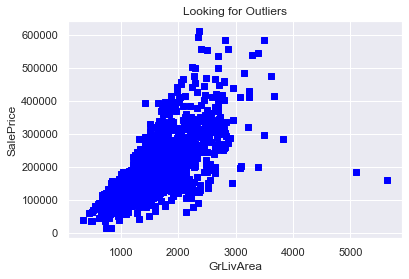

In [161]:
plt.scatter(data['Gr Liv Area'], data['SalePrice'], c = "blue", marker = "s")
plt.title("Looking for Outliers")#  plot over 4k square foot outliers
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()


data = data[data['Gr Liv Area'] < 4000]#remove these outliers





We can see that houses with a living area above 4000sq ft are outliers and these need to be removed. Taking out these valid data points reduced RMSE by 15%.

In [162]:
corr_df = pd.DataFrame(data.corr()['SalePrice'])# split up over .5 correlation coefficient
strong_pos = corr_df['SalePrice'] > .5# strong positive correlation
strong_neg = corr_df['SalePrice'] < (-.3)# strong negative
strong_corr_df = corr_df[strong_pos | strong_neg]
strong_corr_df.drop(index = 'SalePrice',inplace=True)

## EDA

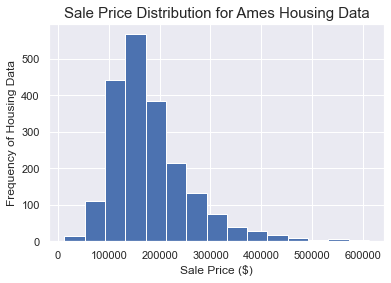

In [163]:
plt.hist(data['SalePrice'],bins=15)
plt.title('Sale Price Distribution for Ames Housing Data',size=15)
plt.xlabel('Sale Price ($)',size=12)
plt.ylabel('Frequency of Housing Data',size=12);

The sale prices are skewed to the right, it could mean that outlier values in the upper range are skewing the values. We could fix this by taking the log of the sales price. 

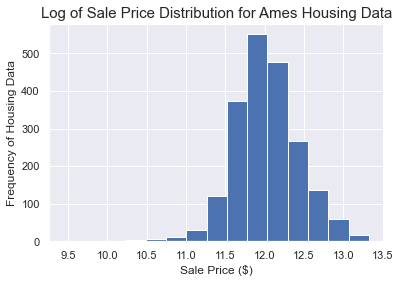

In [164]:
plt.hist(np.log(data['SalePrice']),bins=15)
plt.title('Log of Sale Price Distribution for Ames Housing Data',size=15)
plt.xlabel('Sale Price ($)',size=12)
plt.ylabel('Frequency of Housing Data',size=12);

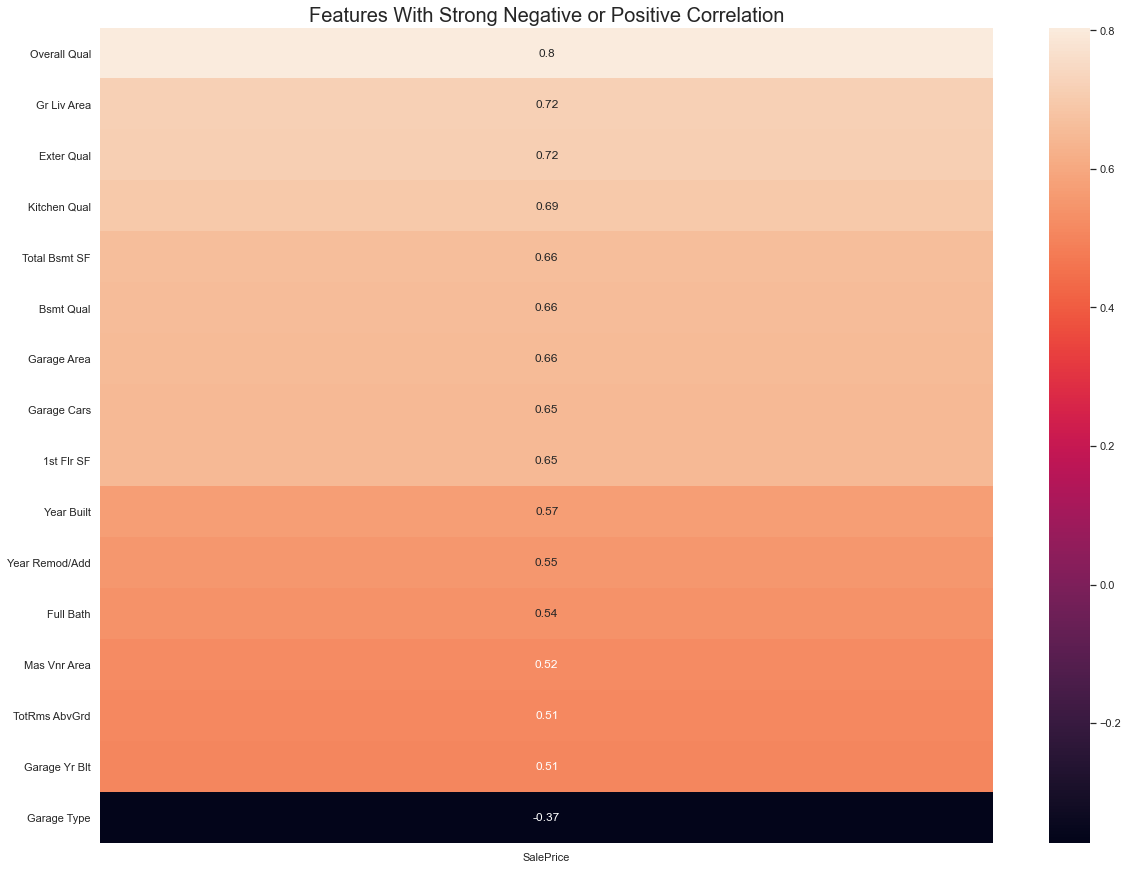

In [165]:

sns.set(style="darkgrid")# plot strong coefficient values
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(strong_corr_df.sort_values('SalePrice',ascending=False),annot = True)
plt.title('Features With Strong Negative or Positive Correlation',{'fontsize': 20});

In [166]:
strongcorr = ['Overall Qual','Exter Qual','Kitchen Qual', 'Gr Liv Area']
medium_corr = ['Total Bsmt SF','Bsmt Qual', 'Garage Area','1st Flr SF']


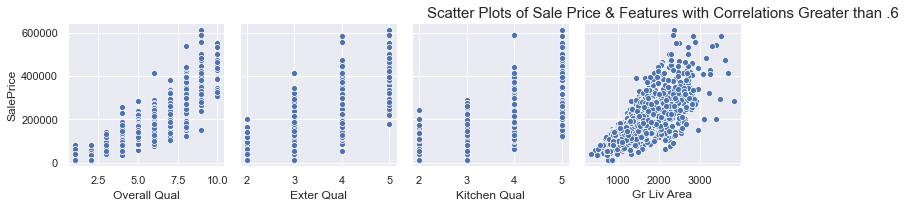

In [167]:
sns.pairplot(data, x_vars=strongcorr, y_vars=['SalePrice'])

plt.title('Scatter Plots of Sale Price & Features with Correlations Greater than .6',size=15);
# plot high correlation columns


As overall quality increase along the 1-10 scale, the price rises accordingly. Exterior Quality also experiences a similiar relatinship along the 1-10 axis. Gr living area follow a linear realtionship but gets less accurate as values become larger.

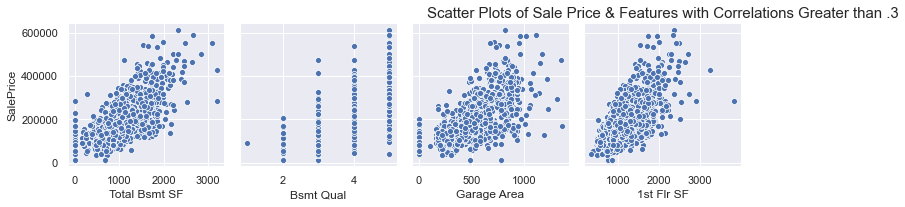

In [168]:
sns.pairplot(data, x_vars=medium_corr, y_vars=['SalePrice'])

plt.title('Scatter Plots of Sale Price & Features with Correlations Greater than .3',size=15);

Total Basmt follows a linear relationship to the sales price of the house. Basement quality also follows a similiar relationship but follows along a 1-10 scale. Garage Area is all over the place but is possibly influneced by quality. 1st floor square footage also follows a similiar linear relationship.

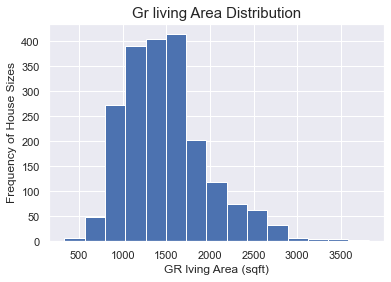

In [169]:
plt.hist(data['Gr Liv Area'],bins=15)
plt.title('Gr living Area Distribution',size=15)
plt.xlabel('GR lving Area (sqft)',size=12)
plt.ylabel('Frequency of House Sizes',size=12);

The distribution of Gr Living Area is skewed to the right and could benefit from log transformation.

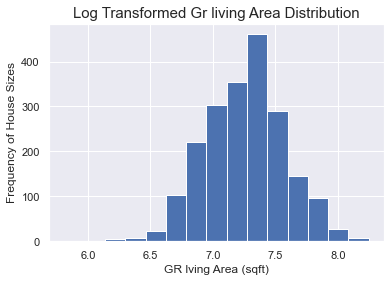

In [170]:
plt.hist(np.log(data['Gr Liv Area']),bins=15)
plt.title('Log Transformed Gr living Area Distribution',size=15)
plt.xlabel('GR lving Area (sqft)',size=12)
plt.ylabel('Frequency of House Sizes',size=12);

The distribution is normal when the log tranformation is taken.

In [171]:
data['log_gr_living_area'] = np.log(data['Gr Liv Area'])# log tranform this variable

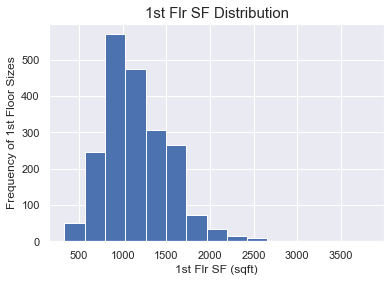

In [172]:
plt.hist(data['1st Flr SF'],bins=15)
plt.title('1st Flr SF Distribution',size=15)
plt.xlabel('1st Flr SF (sqft)',size=12)
plt.ylabel('Frequency of 1st Floor Sizes',size=12);

The distribution is normal enough and doesnt require a log transformation

In [173]:
#feature engineering of high performing features
data['quality_score'] = data['Exter Qual'] * data['Kitchen Qual'] * data['Overall Qual'] * data['Bsmt Qual']
data['size_score'] = data['log_gr_living_area'] * data['1st Flr SF']# 
data['age'] = data['Year Built'] + data['Year Remod/Add']
#age
data.drop(columns = ['Year Built','Year Remod/Add'],inplace=True)

Added three new features based on high correlation, normal skew and, linearity.

In [174]:
corr_df = pd.DataFrame(data.corr()['SalePrice'])# split up over .5 correlation coefficient
strong_pos = corr_df['SalePrice'] > .5# strong positive correlation
strong_neg = corr_df['SalePrice'] < (-.3)# strong negative
strong_corr_df = corr_df[strong_pos | strong_neg]
strong_corr_df.drop(index = 'SalePrice',inplace=True)

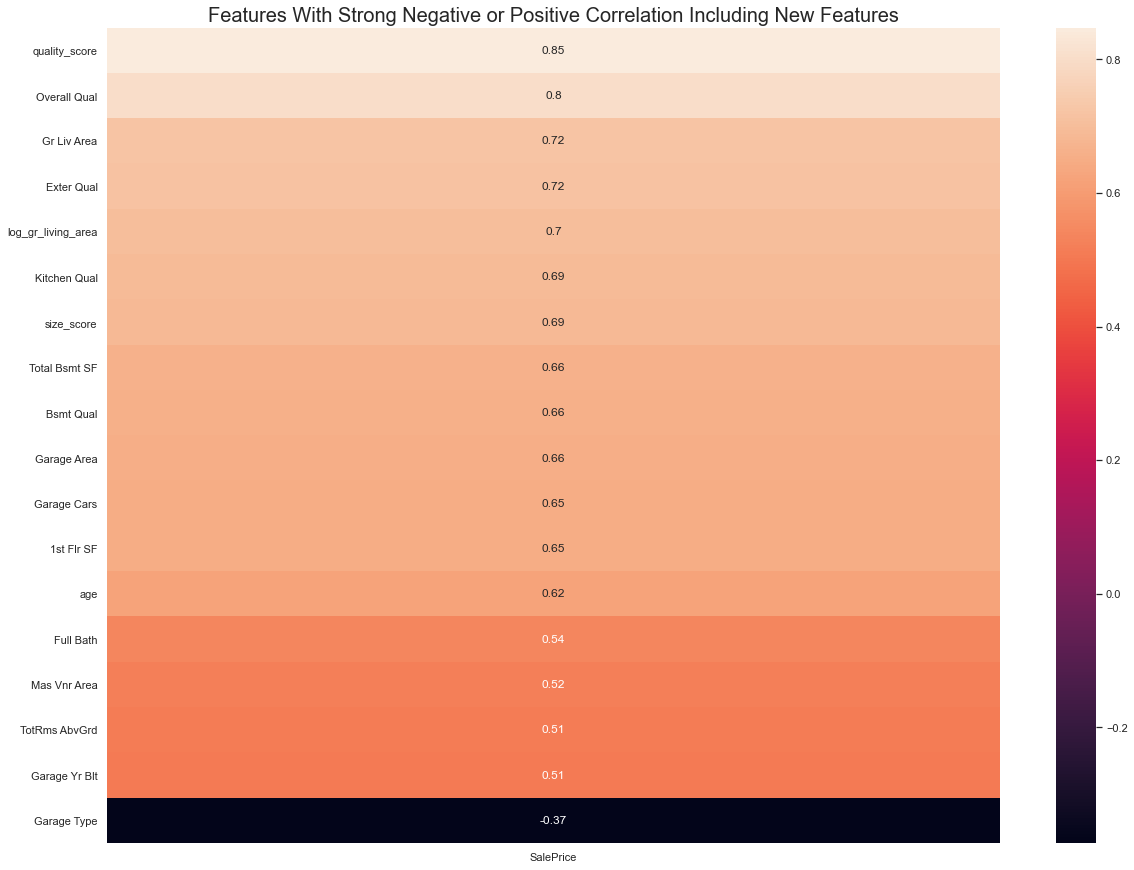

In [175]:
sns.set(style="darkgrid")# plot strong coefficient values
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(strong_corr_df.sort_values('SalePrice',ascending=False),annot = True)
plt.title('Features With Strong Negative or Positive Correlation Including New Features',{'fontsize': 20});

All our new features are performing have an .5 correlation. These are good features and we need to include them in our model.

In [176]:
new_features = ['quality_score','size_score','age']

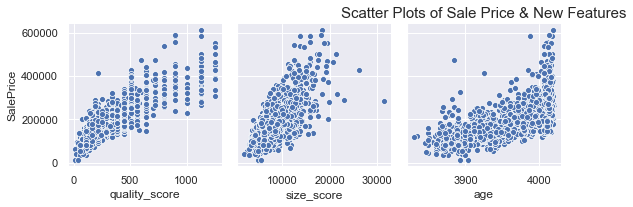

In [177]:
sns.pairplot(data, x_vars=new_features, y_vars=['SalePrice'])

plt.title('Scatter Plots of Sale Price & New Features',size=15);

All of our new features have a linear relationship SalePrice except age once the score gets above 4000.

In [178]:
data = data[data['age'] < 4000]# removing age scores above 4000

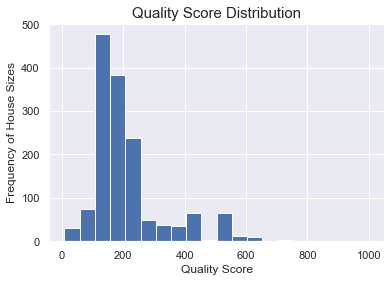

In [179]:
plt.hist(data['quality_score'],bins=20)
plt.title('Quality Score Distribution',size=15)
plt.xlabel('Quality Score',size=12)
plt.ylabel('Frequency of House Sizes',size=12);

This score is skewed to the right, could beneift from a log tranformation

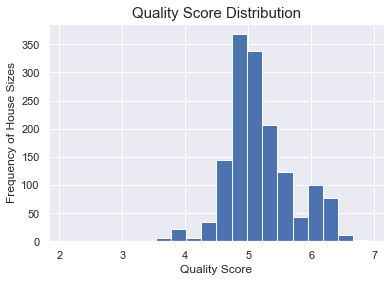

In [180]:
plt.hist(np.log(data['quality_score']),bins=20)
plt.title('Quality Score Distribution',size=15)
plt.xlabel('Quality Score',size=12)
plt.ylabel('Frequency of House Sizes',size=12);

The log transformation helps normalize the distribution

In [181]:
data['log_quality_score'] = np.log(data['quality_score'])

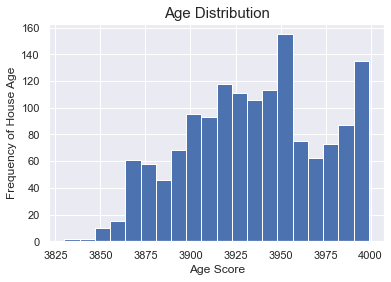

In [182]:
plt.hist(data['age'],bins=20)
plt.title('Age Distribution',size=15)
plt.xlabel('Age Score',size=12)
plt.ylabel('Frequency of House Age',size=12);

Age score is not normally distributed and should not be included in our model.
Size score is normally distributed and will be included.


In [183]:
data.drop(columns = 'age',inplace=True)

In [184]:
zoning_dummys = pd.get_dummies(data, columns = ['MS Zoning','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Sale Type'], drop_first=True)
data = pd.concat([data, zoning_dummys],axis=1)# get dummies and concatenate to DF



In [185]:
feat_list = data.drop(columns = ['SalePrice'])# drop target from features
names = feat_list.select_dtypes(include ='number') 
first = list(names.columns)# get feature list
features = set(first)

## Model Prep



In [186]:
X = data[features]
y = data["SalePrice"]# split in to test and train sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

In [188]:
len(X_train.columns)

222

In [44]:
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

## Modeling 

### Baseline Model

In [45]:
y_pred = y_train.mean()
baseline  = np.sqrt(((y-y_pred)**2).mean())
print(f'the baseline RMSE is {baseline[0]}')

the baseline RMSE is 58204.17742374888


'This baseline model only predicts the mean and serves as the most simplistic model possible. With an RMSE of 58204, our predictions are off by $80,000 give or take. This is a very poor model! If we can build any other model significantly better than this baseline, then we'll have made a model that is better than blindly guessing the average Sale Price.'

### Linear Regression

In [46]:
lr = LinearRegression()
lr.fit(X_test, log_y_test)

lr.fit(X_train, log_y_train)# fit linear regression model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
#preds = model.predict(X)
def rmse(y_true,y_pred):
    
    # important to exponentiate here because we used log(y)
    mse = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [48]:
preds = lr.predict(X_train)
print(f'linear regression train score is {rmse(np.exp(log_y_train),np.exp(preds))}')

linear regression train score is 15343.612131545779


In [49]:
preds = lr.predict(X_test)
print(f'linear regression test score is {rmse(np.exp(log_y_test),np.exp(preds))}')

linear regression test score is 19414.22895560978


The model is significantly overfit, but is performing well given the amount of features

In [50]:
lr_scores = cross_val_score(lr, X, y, cv=3,scoring = make_scorer(rmse))
lr_scores.mean()

20834.999277770574

The cross val score is close enough to our test score for us to trust it

### Scale

In [192]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)# We must scale the data before regularization

### Ridge Model

In [193]:
ridge_model = Ridge(alpha=10)
ridge_model.fit(Z_train, log_y_train)


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [202]:
ridge_train_preds = ridge_model.predict(Z_train)
ridge_test_preds = ridge_model.predict(Z_test)

coef = ridge_model.coef_

In [195]:
ridge_crossval_rmse = cross_val_score(ridge_model, X, y, cv=3,scoring = make_scorer(rmse))
ridge_crossval_rmse.mean()

19959.455196254476

The cross val is close enough to the test rmse

In [196]:
print(f'ridge train RMSE is {rmse(np.exp(log_y_train),np.exp(ridge_train_preds))}')
print(f'ridge test RMSE is {rmse(np.exp(log_y_test),np.exp(ridge_test_preds))}')

ridge train RMSE is 15748.458882573843
ridge test RMSE is 19201.886560788313


The model is overfit but performing on par with Linear Regression

### Lasso

In [238]:
lasso_model = Lasso(.001)

# Fit.
lasso_model.fit(Z_train, log_y_train)


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [239]:
lasso_crossval_rmse = cross_val_score(lasso_model, X, y, cv=3,scoring = make_scorer(rmse))
lasso_crossval_rmse.mean()

21175.78171225665

Cross val is similiar enough to test rmse to be ok

In [240]:
lasso_train_preds = lasso_model.predict(Z_train)
lasso_test_preds = lasso_model.predict(Z_test)

In [241]:
print(f'lasso train RMSE is {rmse(np.exp(log_y_train),np.exp(lasso_train_preds))}')
print(f'lasso test RMSE is {rmse(np.exp(log_y_test),np.exp(lasso_test_preds))}')

lasso train RMSE is 16248.887978167617
lasso test RMSE is 18734.034562324865


The lasso model was on par with the ridge model, at 19309 rmse and this is the best score 


## Model Selection

|             | Train RMSE | Test RMSE|
|:-----------:|----------|---------|
| Linear Regression    | 15361   | 19429   |
| LR with Ridge    | 15678   | 19228|
| LR with LASSO    |16248    |18734
|


The linear regression with ridge regularization and the one with lasso regularization are both performing equally. These have an RMSE of 18734, but since the ridge model doesnt bring coefficnets to 0, we will choose. We are choosing the Lasso Model

## Model Evaluation

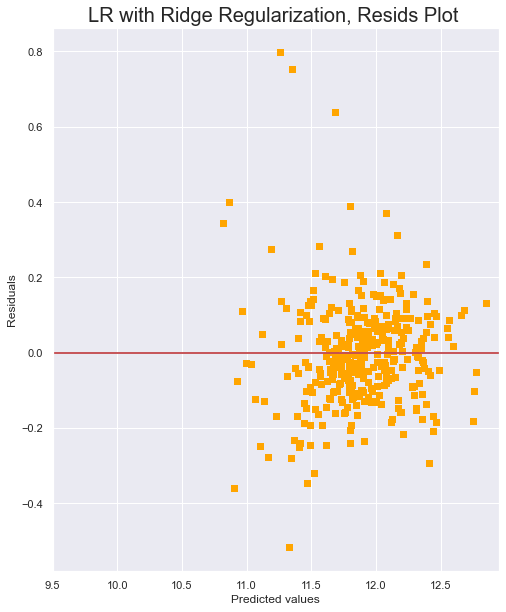

In [242]:
plt.scatter(lasso_test_preds, lasso_test_preds - log_y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("LR with Ridge Regularization, Resids Plot ",{'fontsize': 20}# plotting ridge resids plot 
         )
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.xlim(9.5)
plt.hlines(y = 0, xmin = 0, xmax = 500000, colors='r', linestyles='solid')
plt.axhline(0, c = "r")

plt.show()


Mean is around zero which is what we are looking for. Independence of errors, no patterns.

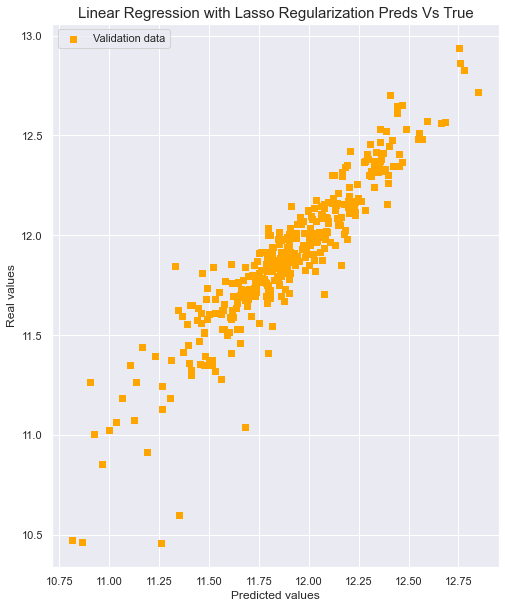

In [244]:
plt.scatter(lasso_test_preds,log_y_test,c = "orange", marker = "s", label = "Validation data");
plt.title("Linear Regression with Lasso Regularization Preds Vs True",size=15)
plt.xlabel("Predicted values")# plotting real vs true plot
plt.ylabel("Real values")
plt.legend(loc = "upper left");




The real vs predicted values hold true with homoskedasticity of errors. 

Text(0, 0.5, 'Errors')

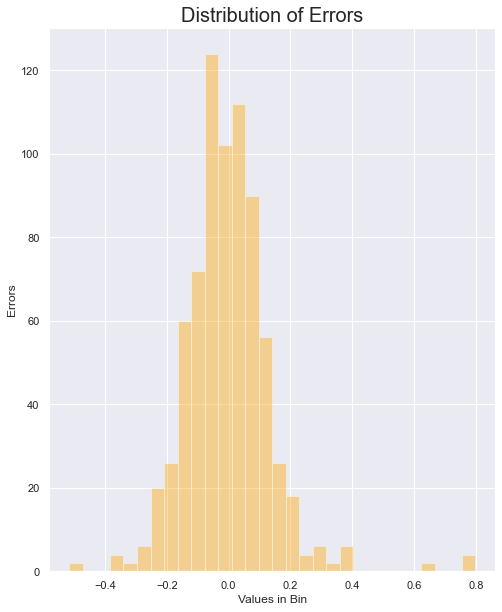

In [245]:
sns.distplot(lasso_test_preds-log_y_test, kde=False, bins=30,color= 'orange')
plt.plot(figsize=(30,20))
plt.title("Distribution of Errors",{'fontsize': 20})
plt.xlabel("Values in Bin")
plt.ylabel("Errors")




Basically normal distribution of errors but a little skewed to the right which falls in line with other plots.

In [247]:
lasso_model.intercept_


array([11.89563656, 11.89563656])

Without any features a house is worth 11$

In [267]:
lasso_coef = lasso_model.coef_



In [264]:
lasso_model_coef = pd.Series(lasso_coef[0], index = X_train.columns)
print('Lasso picked ' +  str(sum(lasso_model_coef != 0)) +  ' variables and eliminated the other '  + str(sum(lasso_model_coef == 0)) + ' variables ') 

Lasso picked 154 variables and eliminated the other 68 variables 


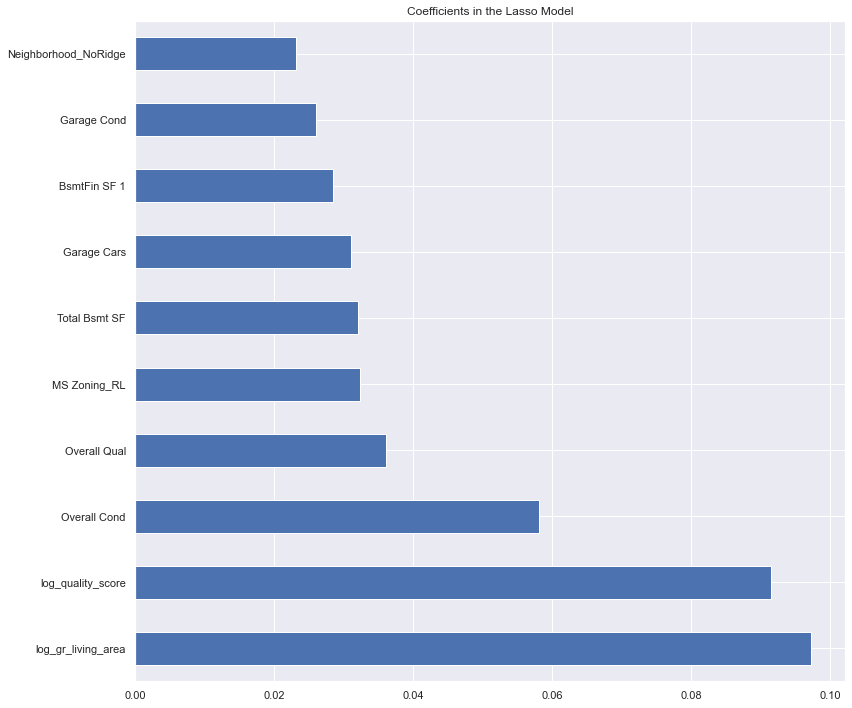

In [284]:
lass_model_df = pd.DataFrame(lasso_coef[0],X_train.columns)
plt.rcParams['figure.figsize'] = (12.0, 10.0)
lasso_model_coef.sort_values(ascending=False).head(10).plot(kind = 'barh')
plt.title('Coefficients in the Lasso Model')
plt.tight_layout()

These are the top features in order of highest effect on sales price. the log_gr living area, log

## Conclusion/ Reccommendations

 When making models for the future, focus on subjective metrics like Overall Qual, Ext Quality, and Overal Cond, these have more of an effect than objective metrics like number of bedrooms or baths. The strategy of examining high correlation features and making new features out of those was succesful and resulted in a model with low error. The missing data strategy was also successful but has to be done in conjunction with the data dictionary. Eliminate outliers in the target variable as these can cause the distribution to become skewed. This will result in the most accurate predictions. 

### Data Dictionary

 - http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
  

 ### References
 

- http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
- http://jse.amstat.org/v19n3/decock.pdf

### Kaggle Submission Area

In [64]:
data = pd.read_csv("../datasets/test.csv")

In [65]:
data.shape
# Kaggle Submission
#Model workflow with validation or holdout set in order to submit

(878, 80)

In [66]:
data['Lot Frontage'].fillna(data['Lot Frontage'].mean(),inplace = True)# fill missing lot frontage wth mean value



data.replace({'Ex': 5,'Gd' : 4,'Ta': 3,'Fa': 2,'Po':1,'Na':0,'TA':3},inplace=True)

data.replace({'GLQ': 6,'ALQ' : 5,'BLQ': 4,'Rec': 3,'LWQ':2,'LwQ':2,'Unf':1,'NA':0},inplace=True)

data.replace({'Y': 4,'Av' : 3,'Mn': 2,'No': 1,'NA':0},inplace=True)

In [67]:
data.shape

(878, 80)

In [68]:
data.replace({'Gd': 4,'Av' : 3,'Mn': 2,'No': 1,'NA':0},inplace=True)

data.replace({'Fin': 4,'RFn' : 3,'Unf': 2,'NA':0},inplace=True)

data.replace({'2Types': 4,'Detchd' : 3,'Basment': 2,'BuiltIn': 2,'Attchd':2,'CarPort':1,'NA':0},inplace=True)

data.replace({'SBrkr':3,'FuseA':2,'FuseF':1,'FuseP':1,'Mix':2},inplace=True)   

data['Street'].replace({'Grvl':2,'Pave':1,'NA':0})

data.replace({'Y':2,'P':1,'N':0},inplace=True)

data.replace({'Ex':4,'Gd':3,'TA':2,'Fa':1,'NA':0},inplace=True)

In [69]:
data.shape

(878, 80)

In [70]:
data['Land Slope'].replace({'Gtl':3,'Mod':2,'Sev':1},inplace=True)
data['Lot Shape'].replace({'Reg':4,'IR1':3,'IR2':2,'IR3':1},inplace=True)

data['Utilities'].replace({'AllPub':2,'NoSewr':0,'NoSeWa':0},inplace=True)

data['Functional'].replace({'Min2':2,'Min1':2,'Mod':1,'Maj1':0,'Maj2':0},inplace=True)

data.replace({'Norm':2,'Feedr':1,'Artery':0,'RRAn':0,'PosN':3,'PosA':3,'RRAe':0,'RRNn':0,'RRNe':0},inplace=True)
data.replace({'1Fam':3,'TwnhsE':1,'Duplex':1,'Twnhs':1,'2fmCon':1},inplace=True)
data['Pool QC'].fillna(0,inplace=True)

data['Misc Feature'].replace({'Elev':3,'Gar2':3,'Othr':1,'Shed':1,'TenC':2},inplace=True)

data['Alley'].replace({'Grvl':1,'Pave':2},inplace=True)



data['Alley'].fillna(0,inplace=True)
data['Fireplace Qu'].fillna(0,inplace=True)

data['Misc Feature'].fillna(0,inplace=True)

data.replace({'GdPrv':3,'MnPrv':1,'GdWo':2,'MnWw':1,'NA':0})
data['Fence'].fillna(0,inplace=True)
#data = data[data['Gr Liv Area'] < 4000]
dummy_list = ['MS Zoning','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Sale Type']
def fill_na(data,col):
    dict_1 = dict(data[col].value_counts(normalize = True))
    keys = list(dict_1.keys())
    values = list(dict_1.values())
    for k,v in dict_1.items():
        data[col] = data[col].fillna(pd.Series(np.random.choice(keys,p=values, size=len(data))))

fill_na(data,'Garage Cond')
fill_na(data,'Garage Type')
fill_na(data,'Garage Qual')
fill_na(data,'Garage Finish')
fill_na(data, 'Garage Yr Blt')
fill_na(data,'Bsmt Exposure')
fill_na(data,'BsmtFin Type 2')
fill_na(data,'Bsmt Qual')
fill_na(data,'Bsmt Cond')

fill_na(data,'BsmtFin Type 1')
fill_na(data,'Mas Vnr Type')
fill_na(data,'Mas Vnr Area')
fill_na(data,'Bsmt Full Bath')
fill_na(data,'Bsmt Half Bath')
fill_na(data,'BsmtFin SF 1')
fill_na(data,'BsmtFin SF 2')
fill_na(data,'Bsmt Unf SF')
fill_na(data,'Total Bsmt SF')
fill_na(data,'Garage Cars')
fill_na(data,'Garage Area')
for i in dummy_list:
    fill_na(data,i)
data['Garage Type'] = data['Garage Type'].astype('float64')
data['Garage Cars'] = data['Garage Cars'].astype('float64')
data['Garage Area'] = data['Garage Area'].astype('float64')

In [71]:
data['garage_score'] = data['Garage Qual'] * data['Garage Cond'] * data['Garage Qual'] * data['Garage Cond'] * data['Garage Area'] * data['Garage Cars'] * data['Garage Yr Blt'] * data['Garage Finish']
data['basement_score'] = data['Bsmt Full Bath'] * data['Bsmt Half Bath'] * data['BsmtFin Type 2'] * data['BsmtFin SF 2'] * data['Bsmt Unf SF'] * data['Total Bsmt SF'] * data['Bsmt Qual'] * data['Bsmt Cond'] * data['Bsmt Exposure'] * data['BsmtFin Type 1'] * data['BsmtFin SF 1']
data['bath_score'] = data['Full Bath'] * data['Half Bath'] 
data['ext_score'] =  data['Exter Qual'] * data['Exter Cond']  
data['outdoor_score'] =  data['Paved Drive'] * data['Wood Deck SF'] * data['Open Porch SF'] * data['Enclosed Porch'] * data['3Ssn Porch'] * data['Screen Porch']
data['pool_score'] = data['Pool Area'] * data['Pool QC']
data['fireplace_score'] = data['Fireplaces'] * data['Fireplace Qu']
data['kitchen_score'] = data['Kitchen AbvGr'] * data['Kitchen Qual']
data['misc_score'] = data['Misc Val'] * data['Misc Feature']
data['land_score'] = data['Lot Frontage'] * data['Lot Area'] * data['Alley'] * data['Lot Shape'] * data['Utilities'] * data['Land Slope']
data['quality_score'] = data['Overall Qual'] * data['Overall Cond'] 
data['size_score']  = data['1st Flr SF'] * data['2nd Flr SF'] * data['Low Qual Fin SF'] * data['Gr Liv Area']

In [72]:
data.shape

(878, 92)

In [73]:
for i in dummy_list:
    fill_na(data,i)
data = pd.get_dummies(data, columns = ['MS Zoning','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Sale Type'], drop_first=True)

data.fillna(0,inplace=True)



# this code is adpated from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook

In [74]:
names = data.select_dtypes(include ='number') 
features  = names.columns

In [75]:
# filter features
filtered_val = data[features]


In [76]:
len(set(filtered_val.columns))

181

In [77]:
X_list = list(X_train)
val_list = list(filtered_val)

In [78]:
for i in val_list:
    if i not in X_list:
        filtered_val.drop(columns = i,inplace=True)

In [79]:
X_train.shape

(1113, 222)

In [80]:
filtered_val.shape

(878, 145)

In [81]:
preds = preds.flatten()

In [82]:
preds[:10]

array([12.15494978, 12.15494978, 11.66655767, 11.66655767, 11.69891557,
       11.69891557, 12.31327353, 12.31327353, 12.12867602, 12.12867602])

In [83]:

# We need to submit to Kaggle in the appropriate form of .csv

# create prediction Series
preds_col = pd.Series(preds, name = "SalePrice")

# combine with Id
id_col    = data["Id"]
output = pd.concat([id_col, preds_col], axis = 1)


In [84]:
len(output)

878

In [85]:
output.to_csv("../output/submission.csv",index=False)

In [86]:
output.shape

(878, 2)